In [1]:
PATH_TRAIN = "../../data/train_LPC_RP.csv" 
PATH_TEST = "../../data/test_LPC_RP.csv"
PATH_SAVE = "../../data/sub_LPC_RP_david_sergey.csv"

In [2]:
import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from catboost import CatBoostRegressor
import xgboost as xgb
import catboost as cat
from sklearn.svm import SVC
from sklearn import linear_model
from scipy.spatial.distance import euclidean
from matplotlib import cm

import pickle

from hyperopt import hp, tpe,Trials
from hyperopt.fmin import fmin
from collections import OrderedDict

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,WhiteKernel,RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
def score_i(y,y_sim):
    loss_i = np.mean(np.abs((y_sim - y) / (np.abs(y_sim) + np.abs(y))))
    return 100*(1-loss_i)

In [4]:
train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)

In [5]:
train["epoch"] = pd.to_datetime(train["epoch"])
test["epoch"] = pd.to_datetime(test["epoch"])

In [6]:
train["day"] = train["epoch"].dt.day
test["day"] = test["epoch"].dt.day

In [7]:
train["measurement_interv"] = pd.to_datetime(train["epoch"]).diff().apply(lambda x: x.total_seconds())
for sat in train.sat_id.unique():
    train["measurement_interv"].iloc[train[train.sat_id == sat].index[0]] = train["measurement_interv"].iloc[train[train.sat_id == sat].index[1]]

In [8]:
test["measurement_interv"] = pd.to_datetime(test["epoch"]).diff().apply(lambda x: x.total_seconds())
for sat in test.sat_id.unique():
    test["measurement_interv"].iloc[test[test.sat_id == sat].index[0]] = test["measurement_interv"].iloc[test[test.sat_id == sat].index[1]]

In [9]:
plotler = train.loc[train.sat_id == 37]
day = 31

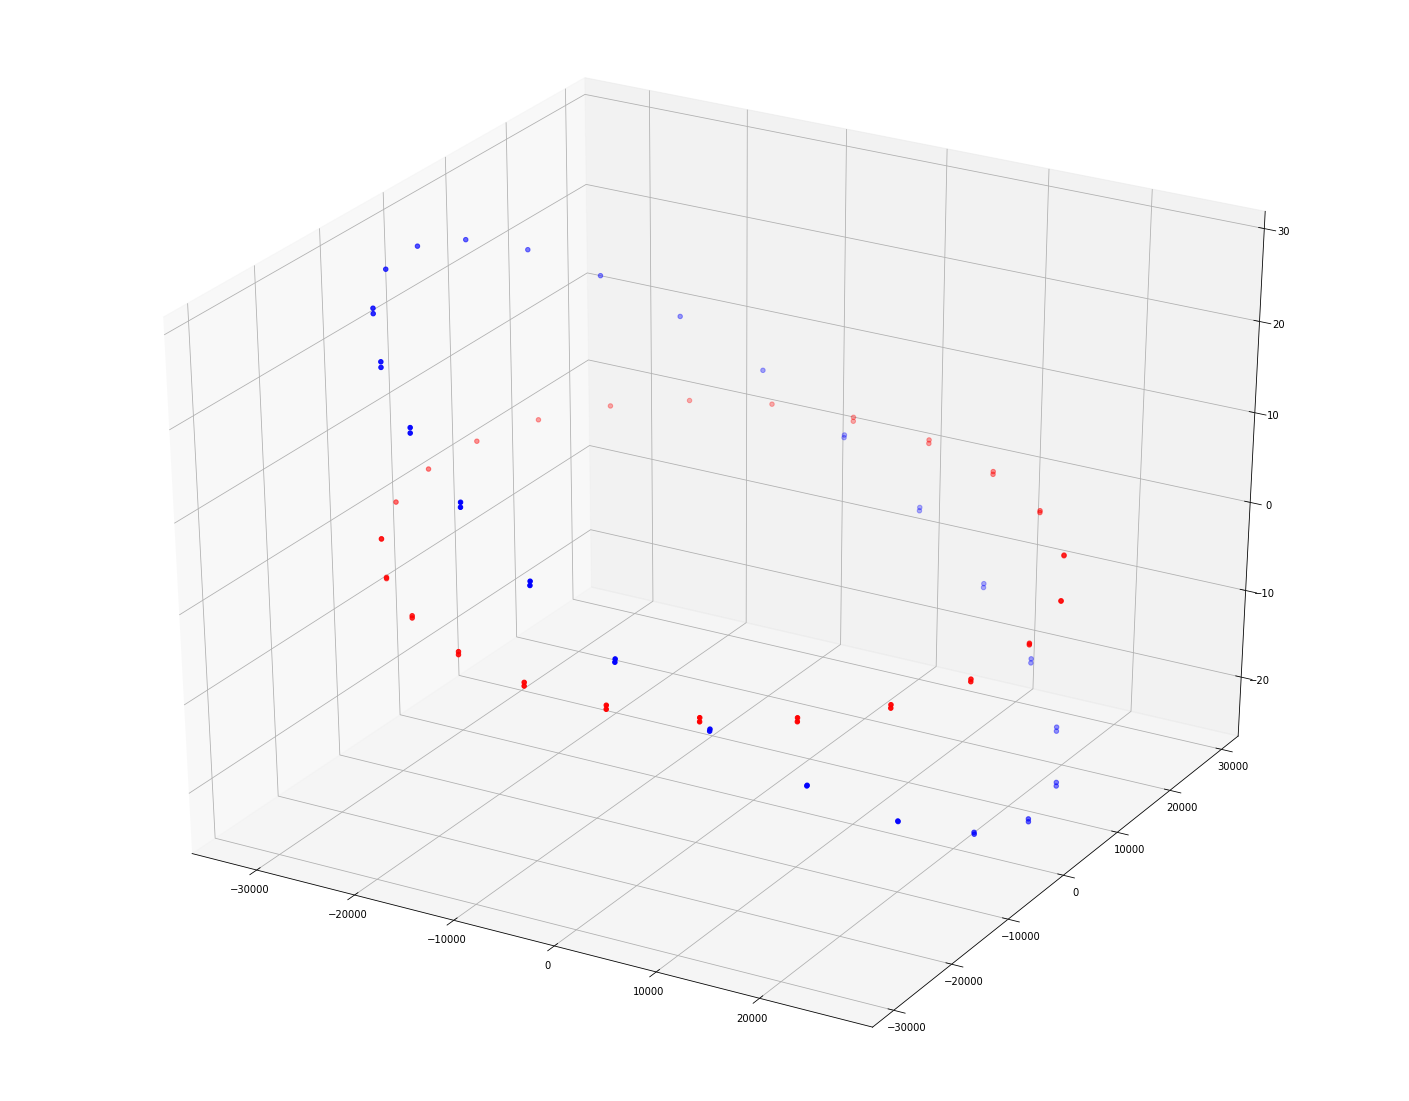

In [10]:
plotler = train.loc[train.sat_id == 37]
day = 31

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (25,20))
ax = fig.add_subplot(111, projection='3d')

zline = plotler.loc[plotler.day == day, "z"]
xline = plotler.loc[plotler.day == day, "x"]
yline = plotler.loc[plotler.day == day, "y"]

zline_sim = plotler.loc[plotler.day == day, "z_sim"]
xline_sim = plotler.loc[plotler.day == day, "x_sim"]
yline_sim = plotler.loc[plotler.day == day, "y_sim"]


#ax.plot(np.array(pl0tler.iloc[xmin]["x"]),np.array(pl0tler.iloc[xmin]["y"]),np.array(pl0tler.iloc[xmin]["z"]))


ax.scatter(xline, yline, zline, c = 'blue')
ax.scatter(xline_sim, yline_sim, zline_sim, c ='red')
#ax.scatter(xline_sim2, yline_sim2, zline_sim2, c ='green')

In [11]:
def make_pred_model_dict(target_col_,sat_,window):
    
    target_col_ = [target_col_]
    train_test = train.loc[train.sat_id == sat_]
    test_test = test.loc[test.sat_id == sat_].reset_index(drop = True)
    

    train_test["x_err"] = train_test[target_col_]#train_test.apply(lambda x: x[target_col_] - x[target_col_ + "_sim"],axis = 1)
    train_test = train_test.loc[train_test["measurement_interv"] > 1]
    test_test = test_test.loc[test_test["measurement_interv"] > 1]
    
    scaler = StandardScaler()
    
    train_test["x_err"] = scaler.fit_transform(np.array(train_test["x_err"]).reshape(-1, 1))
    
    minus_featus = window
    for i in range(1,minus_featus):
        train_test["x_minus"+ str(i)] = train_test["x_err"].shift(i)
    
    train_test.dropna(inplace = True)

    train_test.reset_index(drop = True,inplace = True)
    test_test.reset_index(drop = True,inplace = True)
    
    
    cols_min =["x_minus"+ str(i) for i in range(1,minus_featus)]
    
    additional_cols = []     #THIS IS LEFT FOR THE ORGANIZERS, you might want to add certain features here to improve accuracy(like predict the distance from earth or something, or predict on Vx,
    #then add it as a feature when predicting x, this will most likely improve score by quite a bit, but I dont have time to follow up on this. You can just make predictions on it, then add it to the test
    #set as a column and it will automatically be added when making predictions below), here i am just making a univariate time series prediction.
    
    cols_min += additional_cols
    
    X_train, X_test, y_train, y_test = train_test_split(train_test[cols_min], train_test["x_err"], test_size=0.1, random_state=42,shuffle = False)

    model = GaussianProcessRegressor(kernel = Matern()).fit(train_test[cols_min],train_test["x_err"])
    
    cols = ["x_minus"+ str(i) for i in range(1,minus_featus)]
    stop = len(cols)
    preds = []
    
    history = np.array(X_test.iloc[-1]).reshape((1,-1))
    
    for i in range(len(test_test) + 1):
        
        yhat = model.predict(history)
        
        if i != len(test_test):
            history = np.insert(history,0,yhat)[:stop].reshape((1,-1))
            history = np.concatenate([history.reshape(-1),test_test.iloc[i][additional_cols]]).reshape(1,-1)
        
        preds.append(yhat[0])
    preds = np.array(preds).reshape(-1)[1:]
    
    preds = scaler.inverse_transform(preds)
    return preds

In [12]:
"""
[20,
 22,
 37,
 127,
 159,
 162,
 252,
 253,
 277,
 362,
 390,
 391,
 473,
 481,
 502,
 515,
 523,
 524,
 548,
 549,
 588]
 """

'\n[20,\n 22,\n 37,\n 127,\n 159,\n 162,\n 252,\n 253,\n 277,\n 362,\n 390,\n 391,\n 473,\n 481,\n 502,\n 515,\n 523,\n 524,\n 548,\n 549,\n 588]\n '

In [13]:
sat11 = 100

In [14]:
preds_dict = {}

target_cols = ["x","y","z"]

for targ in target_cols:
    print(targ)
    preds_dict[targ] = make_pred_model_dict(targ,sat11,45)

x


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00065091]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


y


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.48459387]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 45, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


z


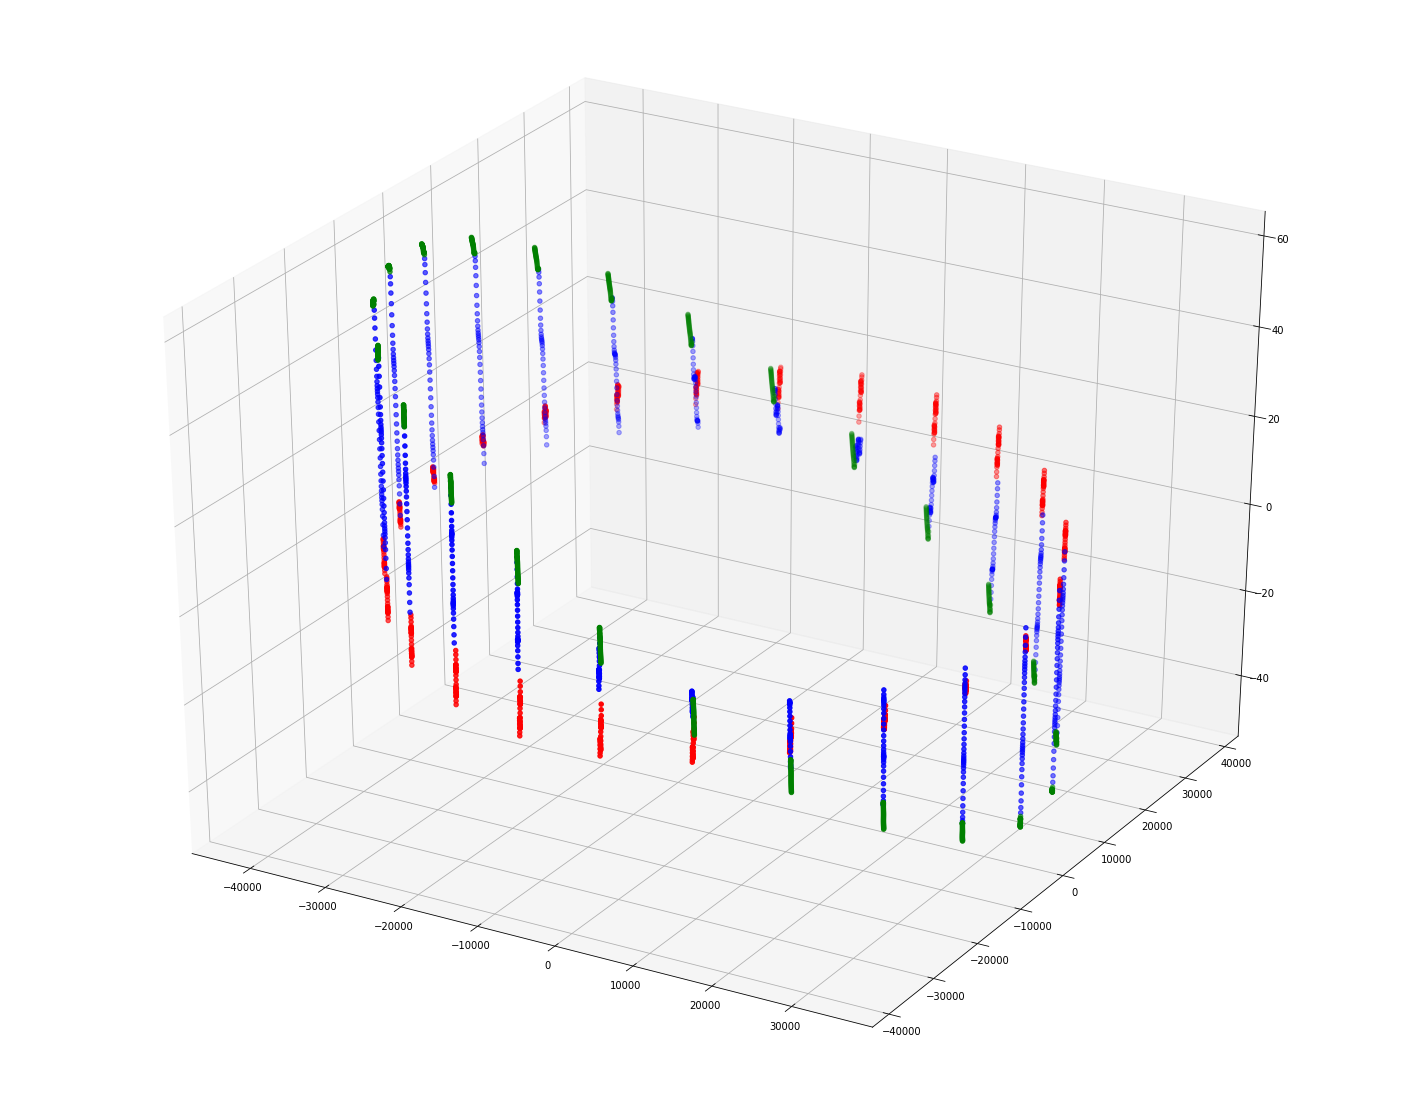

In [15]:
preds = preds_dict
plotler = train.loc[train.sat_id == sat11]

day = 31

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (25,20))
ax = fig.add_subplot(111, projection='3d')

zline = plotler["z"]
xline = plotler["x"]
yline = plotler["y"]

zline_sim = plotler["z_sim"]
xline_sim = plotler["x_sim"]
yline_sim = plotler["y_sim"]

xline_sim2 = preds_dict["x"]
yline_sim2 = preds_dict["y"]
zline_sim2 = preds_dict["z"]


#ax.plot(np.array(pl0tler.iloc[xmin]["x"]),np.array(pl0tler.iloc[xmin]["y"]),np.array(pl0tler.iloc[xmin]["z"]))

ax.scatter(xline, yline, zline, c = 'blue')
ax.scatter(xline_sim, yline_sim, zline_sim, c ='red')
ax.scatter(xline_sim2, yline_sim2, zline_sim2, c ='green')

In [16]:
target_cols = ["x","y","z","Vx","Vy","Vz"]

In [ ]:
hard_sat_dict = {}

for sat in test.sat_id.unique():
    print(sat)
    individual_sat_dict = {}
    for col in target_cols:
        preds = make_pred_model_dict(col,sat,45)
        individual_sat_dict[col] = preds
    hard_sat_dict[sat] = individual_sat_dict

0


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.16603342]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00394996]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03033461]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


1


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00689638]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.60297615]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00285441]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWar

2


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.3775831]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.2604672e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


3


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01081778]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00011608]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


4


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.43375294]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.48295779]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.55721277e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


5


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.05563542]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.16922729]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.06534586]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


6
7


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00083149]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.09232547]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


8


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00270587]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.29509127]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00619847]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


9


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.03983688e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0828451]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.16833657]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceW

10


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.08095855]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.07825741]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.13397837e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


11


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.08060427]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00088865]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


12


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00652666]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.02071559]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01733065]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


13


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00569747]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01874119]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.93337822e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


14


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.24578595]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


15


/Users/bamasa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.35876338]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


In [ ]:
submission = pd.read_csv("submission.csv")

In [ ]:
submission["sat_id"] = test.sat_id

In [ ]:
submission["measurement_interv"] = test["measurement_interv"]

In [ ]:
print("HI") 

In [ ]:
sats = hard_sat_dict.keys()

In [ ]:
for sat in sats:
    for tcol in target_cols:
        leng = len(submission.loc[(submission.sat_id == sat) & (submission.measurement_interv > 1),tcol])
        submission.loc[(submission.sat_id == sat) & (submission.measurement_interv > 1),tcol] = hard_sat_dict[sat][tcol][:leng]
        
idxes = []

for sat in sats:
    idxes += list(submission.loc[(submission.sat_id == sat) & (submission.measurement_interv < 1)].index)
    
    
for ix in idxes:
    for targ in target_cols:
        submission[targ].iloc[ix] = submission[targ].iloc[ix-1]

In [ ]:
submission = submission[["id","x","y","z","Vx","Vy","Vz"]]

In [ ]:
submission["id"] = submission["id"].astype(int)

In [ ]:
submission.to_csv(PATH_SAVE,index=False)

In [ ]:
satt = 159


plotler = train.loc[train.sat_id == satt]

preds_dict11 = submission.loc[submission.sat_id == satt]

day = 31

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (25,20))
ax = fig.add_subplot(111, projection='3d')

zline = plotler["z"]
xline = plotler["x"]
yline = plotler["y"]

zline_sim = plotler["z_sim"]
xline_sim = plotler["x_sim"]
yline_sim = plotler["y_sim"]

xline_sim2 = preds_dict11["x"]
yline_sim2 = preds_dict11["y"]
zline_sim2 = preds_dict11["z"]


#ax.plot(np.array(pl0tler.iloc[xmin]["x"]),np.array(pl0tler.iloc[xmin]["y"]),np.array(pl0tler.iloc[xmin]["z"]))

ax.scatter(xline, yline, zline, c = 'blue')
ax.scatter(xline_sim, yline_sim, zline_sim, c ='red')
ax.scatter(xline_sim2, yline_sim2, zline_sim2, c ='green')